In [82]:
import json
from rdflib import Graph, Literal, BNode, Namespace, RDF, URIRef
import holoviews as hv
import networkx as nx

In [83]:
# Create a graph
g = Graph()

def create_rdf_graph(data):
    ARXIV = Namespace("http://arxiv.org/")

    # Create a URI for this paper
    paper = URIRef(ARXIV + data['paper_id'])

    # Add triples using store's add method.
    g.add((paper, RDF.type, ARXIV.Paper))
    g.add((paper, ARXIV.title, Literal(data['metadata']['title'])))
    g.add((paper, ARXIV.discipline, Literal(data['discipline'])))
    g.add((paper, ARXIV.abstract, Literal(data['abstract']['text'])))
    g.add((paper, ARXIV.Author, Literal(data['metadata']['authors'])))

    # Iterating over body_text (assuming it's a list of dictionaries)
    for section in data['body_text']:
        if 'text' in section:
            g.add((paper, ARXIV.body, Literal(section['text'])))

        # Iterating over cite_spans (if it exists in the section)
        if 'cite_spans' in section:
            for cite_span in section['cite_spans']:
                cite_span_bnode = BNode()
                g.add((cite_span_bnode, RDF.type, ARXIV.CiteSpan))
                g.add((cite_span_bnode, ARXIV.text, Literal(cite_span['text'])))
                g.add((cite_span_bnode, ARXIV.citeid, Literal(cite_span['ref_id'])))
                g.add((paper, ARXIV.hasCiteSpan, cite_span_bnode))

        # Iterating over ref_spans (if it exists in the section)
        if 'ref_spans' in section:
            for ref_span in section['ref_spans']:
                ref_span_bnode = BNode()
                g.add((ref_span_bnode, RDF.type, ARXIV.RefSpan))
                g.add((ref_span_bnode, ARXIV.text, Literal(ref_span['text'])))
                g.add((ref_span_bnode, ARXIV.refid, Literal(ref_span['ref_id'])))
                g.add((paper, ARXIV.hasRefSpan, ref_span_bnode))

    # Iterating over bib_entries (assuming it's a dictionary)
    for id, bib_entry in data['bib_entries'].items():
        bib_entry_bnode = BNode()
        g.add((bib_entry_bnode, RDF.type, ARXIV.BibEntry))
        g.add((bib_entry_bnode, ARXIV.bib_entry_raw, Literal(bib_entry['bib_entry_raw'])))
        # Adding contained_arXiv_ids if they exist
        if 'contained_arXiv_ids' in bib_entry:
            for arxiv_id in bib_entry['contained_arXiv_ids']:
                linked_paper = URIRef(ARXIV + arxiv_id['id'])
                g.add((bib_entry_bnode, ARXIV.contained_arXiv_id, linked_paper))
                g.add((paper, ARXIV.cites, linked_paper))
                g.add((bib_entry_bnode, ARXIV.contained_arXiv_text, Literal(arxiv_id['text'])))

    # Iterating over ref_entries (assuming it's a dictionary)
    for id, ref_entry in data['ref_entries'].items():
        ref_entry_bnode = BNode()
        g.add((ref_entry_bnode, RDF.type, ARXIV.RefEntry))
        g.add((ref_entry_bnode, ARXIV.ref_type, Literal(ref_entry['type'])))
        # Adding caption or latex depending on the type of ref_entry
        if 'caption' in ref_entry and ref_entry['type'] == 'figure':
            g.add((ref_entry_bnode, ARXIV.captionfigure, Literal(ref_entry['caption'])))
        elif 'caption' in ref_entry and ref_entry['type'] == 'table':
            g.add((ref_entry_bnode, ARXIV.captiontable, Literal(ref_entry['caption'])))

In [84]:
# Open your jsonl file
with open('dataset.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        create_rdf_graph(data)

In [85]:
# Save the graph in script1.py
import pickle
with open('graph.pkl', 'wb') as f:
    pickle.dump(g, f)

In [86]:
# This query will provide valuable insights on the number and titles of papers in the "Computer Science" discipline. 

q1 = '''
    PREFIX ARXIV: <http://arxiv.org/>
    SELECT ?paper ?title
    WHERE {
        ?paper a ARXIV:Paper ;
               ARXIV:title ?title ;
               ARXIV:discipline "Statistics" .
    }
'''

# Perform the query on the graph
subgraph1 = g.query(q1)

for row in subgraph1:
    print(row)


(rdflib.term.URIRef('http://arxiv.org/2001.01128'), rdflib.term.Literal('Locality-Sensitive Hashing for Efficient Web Application Security\n  Testing'))
(rdflib.term.URIRef('http://arxiv.org/2001.01618'), rdflib.term.Literal('ARA : Aggregated RAPPOR and Analysis for Centralized Differential\n  Privacy'))
(rdflib.term.URIRef('http://arxiv.org/2001.09225'), rdflib.term.Literal('Validity, consonant plausibility measures, and conformal prediction'))
(rdflib.term.URIRef('http://arxiv.org/2001.10741'), rdflib.term.Literal('Extreme Algorithm Selection With Dyadic Feature Representation'))
(rdflib.term.URIRef('http://arxiv.org/2002.04688'), rdflib.term.Literal('fastai: A Layered API for Deep Learning'))
(rdflib.term.URIRef('http://arxiv.org/2002.05411'), rdflib.term.Literal("Analysis and Evaluation of Handwriting in Patients with Parkinson's\n  Disease Using kinematic, Geometrical, and Non-linear Features"))
(rdflib.term.URIRef('http://arxiv.org/2002.05412'), rdflib.term.Literal("Comparison of

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
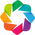

:Graph   [start,end]

In [87]:
hv.extension('bokeh')

# Convert SPARQL results to networkx graph
def sparql_to_networkx_graph(results):
    G = nx.Graph()
    for row in results:
        G.add_edge(str(row[0]), str(row[1]))
    return G

# Convert networkx graph to holoviews graph
def networkx_to_holoviews_graph(G):
    hv_graph = hv.Graph.from_networkx(G, nx.layout.spring_layout)
    return hv_graph

# Graphs for subgraph1
G1 = sparql_to_networkx_graph(subgraph1)
hv_g1 = networkx_to_holoviews_graph(G1)

# Plot with holoviews
hv_g1.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)


In [88]:
# Use Case: Find all papers on a specific topic.
# Justification: This could be useful for a researcher looking to find all papers on a specific topic, e.g., "differential privacy".

q2 = '''
PREFIX arxiv: <http://arxiv.org/>

SELECT ?paper ?title 
WHERE {
  ?paper a arxiv:Paper.
  ?paper arxiv:title ?title.
  FILTER (CONTAINS(?title, "Differential Privacy"))
}
'''

# Perform the query on the graph
subgraph2 = g.query(q2)

for row in subgraph2:
    print(row)

(rdflib.term.URIRef('http://arxiv.org/2003.00973'), rdflib.term.Literal('Differential Privacy at Risk: Bridging Randomness and Privacy Budget'))
(rdflib.term.URIRef('http://arxiv.org/2006.04125'), rdflib.term.Literal('BUDS: Balancing Utility and Differential Privacy by Shuffling'))
(rdflib.term.URIRef('http://arxiv.org/1809.02201'), rdflib.term.Literal('Issues Encountered Deploying Differential Privacy'))


In [89]:
# Graphs for subgraph2
G2 = sparql_to_networkx_graph(subgraph2)
hv_g2 = networkx_to_holoviews_graph(G2)

# Plot with holoviews
hv_g2.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [102]:
# Use Case: Retrieve all papers written by a particular author.
# Justification: This can be beneficial for someone who wants to explore all papers published by a certain author, e.g., "Sudipta Paul".

q3 = '''
PREFIX arxiv: <http://arxiv.org/>

SELECT ?paper ?title
WHERE {
  ?paper a arxiv:Paper.
  ?paper arxiv:Author ?author.
  ?paper arxiv:title ?title.
  FILTER (CONTAINS(?author, "Sansit Patnaik"))
}

'''

# Perform the query on the graph
subgraph3 = g.query(q3)

for row in subgraph3:
    print(row)

(rdflib.term.URIRef('http://arxiv.org/2001.06885'), rdflib.term.Literal('A Ritz-based Finite Element Method for a Fractional-Order Boundary Value\n  Problem of Nonlocal Elasticity'))
(rdflib.term.URIRef('http://arxiv.org/2002.07148'), rdflib.term.Literal('Geometrically Nonlinear Response of a Fractional-Order Nonlocal Model of\n  Elasticity'))
(rdflib.term.URIRef('http://arxiv.org/2002.10244'), rdflib.term.Literal('Fractional-Order Models for the Static and Dynamic Analysis of Nonlocal\n  Plates'))
(rdflib.term.URIRef('http://arxiv.org/2003.10215'), rdflib.term.Literal('Thermodynamics of fractional-order nonlocal continua and its application\n  to the thermoelastic response of beams'))
(rdflib.term.URIRef('http://arxiv.org/2005.10079'), rdflib.term.Literal('Towards a Generalized Approach to Nonlocal Elasticity via\n  Fractional-Order Mechanics'))
(rdflib.term.URIRef('http://arxiv.org/2008.11528'), rdflib.term.Literal('Fractional-Order Structural Stability: Formulation and Application t

In [103]:
# Graphs for subgraph3
G3 = sparql_to_networkx_graph(subgraph3)
hv_g3 = networkx_to_holoviews_graph(G3)

# Plot with holoviews
hv_g3.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [107]:
# Use Case: Find all papers citing a specific paper.
#Justification: This could be helpful for a researcher trying to gauge the impact of a specific work, e.g., a paper with citeID "ff4a579d4abedc40931f2b06ecbeab82c4489299"

q4 = '''
PREFIX arxiv: <http://arxiv.org/>

SELECT DISTINCT ?paper ?title
WHERE {
  ?paper a arxiv:Paper.
  ?paper arxiv:title ?title.
  ?paper arxiv:hasCiteSpan ?citeSpan.
  ?citeSpan arxiv:citeid ?citeID.
  FILTER (?citeID = "ff4a579d4abedc40931f2b06ecbeab82c4489299")
}

'''

# Perform the query on the graph
subgraph4 = g.query(q4)

for row in subgraph4:
    print(row)


(rdflib.term.URIRef('http://arxiv.org/2001.01618'), rdflib.term.Literal('ARA : Aggregated RAPPOR and Analysis for Centralized Differential\n  Privacy'))


In [101]:
# Graphs for subgraph4
G4 = sparql_to_networkx_graph(subgraph4)
hv_g4 = networkx_to_holoviews_graph(G4)

# Plot with holoviews
hv_g4.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [94]:
# This query can give insights into the papers that discuss a specific topic or concept ("Neural Networks" in this case).

q5 = '''
    PREFIX ARXIV: <http://arxiv.org/>
    SELECT ?paper ?title
    WHERE {
        ?paper a ARXIV:Paper ;
               ARXIV:title ?title ;
               ARXIV:abstract ?abstract .
        FILTER(contains(?abstract, "NLP"))
    }
'''

# Perform the query on the graph
subgraph5 = g.query(q5)

for row in subgraph5:
    print(row)

(rdflib.term.URIRef('http://arxiv.org/2004.01970'), rdflib.term.Literal('BAE: BERT-based Adversarial Examples for Text Classification'))
(rdflib.term.URIRef('http://arxiv.org/2005.04147'), rdflib.term.Literal('Quantum Natural Language Processing on Near-Term Quantum Computers'))
(rdflib.term.URIRef('http://arxiv.org/2010.04389'), rdflib.term.Literal('A Survey of Knowledge-Enhanced Text Generation'))
(rdflib.term.URIRef('http://arxiv.org/2010.11574'), rdflib.term.Literal('Exploiting News Article Structure for Automatic Corpus Generation of\n  Entailment Datasets'))
(rdflib.term.URIRef('http://arxiv.org/2012.07437'), rdflib.term.Literal('Rethinking the Promotion Brought by Contrastive Learning to\n  Semi-Supervised Node Classification'))
(rdflib.term.URIRef('http://arxiv.org/2012.10309'), rdflib.term.Literal('Learning Contextual Representations for Semantic Parsing with\n  Generation-Augmented Pre-Training'))
(rdflib.term.URIRef('http://arxiv.org/2012.13985'), rdflib.term.Literal('Explai

In [95]:
# Graphs for subgraph4
G5 = sparql_to_networkx_graph(subgraph5)
hv_g5 = networkx_to_holoviews_graph(G5)

# Plot with holoviews
hv_g5.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [96]:
# Use Case: Retrieve the author, paper id and abstract of a specific paper.
# Justification: This can be useful for a quick overview of a paper's details.

q6 = '''
PREFIX arxiv: <http://arxiv.org/>

SELECT DISTINCT ?paper_id ?abstract
WHERE {
  ?paper a arxiv:Paper.
  BIND(URI("http://arxiv.org/2001.01618") AS ?paper)
  ?paper arxiv:abstract ?abstract.
  BIND(strafter(str(?paper), "http://arxiv.org/") AS ?paper_id)
}
'''

# Perform the query on the graph
subgraph6 = g.query(q6)

# Print the results
for row in subgraph6:
    print(row)


(rdflib.term.Literal('2001.01618'), rdflib.term.Literal('  Differential privacy(DP) has now become a standard in case of sensitive\nstatistical data analysis. The two main approaches in DP is local and central.\nBoth the approaches have a clear gap in terms of data storing,amount of data to\nbe analyzed, analysis, speed etc. Local wins on the speed. We have tested the\nstate of the art standard RAPPOR which is a local approach and supported this\ngap. Our work completely focuses on that part too. Here, we propose a model\nwhich initially collects RAPPOR reports from multiple clients which are then\npushed to a Tf-Idf estimation model. The Tf-Idf estimation model then estimates\nthe reports on the basis of the occurrence of "on bit" in a particular position\nand its contribution to that position. Thus it generates a centralized\ndifferential privacy analysis from multiple clients. Our model successfully and\nefficiently analyzed the major truth value every time.\n'))


In [97]:
# Construct a new subgraph without the abstract for visualization
subgraph6_modified = [(row[0], row[1]) for row in subgraph6]

# Graphs for subgraph6
G6 = sparql_to_networkx_graph(subgraph6_modified)
hv_g6 = networkx_to_holoviews_graph(G6)

# Plot with holoviews
hv_g6.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]